# NLP Project
Urdu to Roman Urdu Transliterator

Help Reference:
https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt

### This notebook contains the training, evaluation, and testing of the model for sentences of length <= 10

In [1]:
# imports 
import csv
import pickle
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input
from tensorflow.keras.layers import Concatenate, Attention
!pip install tensorflow-addons
import tensorflow_addons as tfa
from tensorflow_addons.seq2seq import BasicDecoder
from keras.losses import SparseCategoricalCrossentropy
import time as time
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
import matplotlib.pyplot as plt
import warnings
import random
!pip install evaluate
import evaluate
!pip install rouge_score
import numpy as np
import heapq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 7.7 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/sim

In [2]:
# colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load datasets
with open('/content/drive/MyDrive/NLP Project/cleaned_data/buckets_train_roman.csv', 'r') as f:
    reader = csv.reader(f)
    buckets_train_roman = [[[int(num) for num in sublist.split(',')] for sublist in row] for row in reader]

with open('/content/drive/MyDrive/NLP Project/cleaned_data/buckets_train_urdu.csv', 'r') as f:
    reader = csv.reader(f)
    buckets_train_urdu = [[[int(num) for num in sublist.split(',')] for sublist in row] for row in reader]

with open('/content/drive/MyDrive/NLP Project/cleaned_data/buckets_test_roman.csv', 'r') as f:
    reader = csv.reader(f)
    buckets_test_roman = [[[int(num) for num in sublist.split(',')] for sublist in row] for row in reader]

with open('/content/drive/MyDrive/NLP Project/cleaned_data/buckets_test_urdu.csv', 'r') as f:
    reader = csv.reader(f)
    buckets_test_urdu = [[[int(num) for num in sublist.split(',')] for sublist in row] for row in reader]

In [4]:
# just printing to see if i didnt mess up anything
len(buckets_train_roman[0])

160488

In [5]:
# ok, i didn't mess up anything - now time to build the tensorflow dataset for the model

current_index = 0 # this line is to be changed for each file

# hyperparameters for the dataset
buffer_size = 32000
batch_size = 64

# make tensorflow train and test dataset from the buckets, shuffle the train data and convert all datasets to batches of size 64 (as done in the paper)
train_dataset = tf.data.Dataset.from_tensor_slices((buckets_train_urdu[current_index], buckets_train_roman[current_index]))
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((buckets_test_urdu[current_index], buckets_test_roman[current_index]))
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

In [6]:
# load the tokenizers
with open('/content/drive/MyDrive/NLP Project/tokenizer_roman.pkl', 'rb') as f:
    tokenizer_roman_string = f.read()

tokenizer_roman = pickle.loads(tokenizer_roman_string)

with open('/content/drive/MyDrive/NLP Project/tokenizer_urdu.pkl', 'rb') as f:
    tokenizer_urdu_string = f.read()

tokenizer_urdu = pickle.loads(tokenizer_urdu_string)

In [7]:
# hyperparameters for the model
vocab_tar_size = len(tokenizer_roman.word_index) + 1
vocab_inp_size = len(tokenizer_urdu.word_index) + 1
embedding_dim = 256
units = 1024
steps_per_epoch = 17300 

## Model Architecture:

In [8]:
# code used from the help reference and modified a bit to fit our needs

In [9]:
# encoder
class Encoder(Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, num_layers=3):
      super(Encoder, self).__init__()
      self.batch_sz = batch_sz
      self.enc_units = enc_units
      self.embedding = Embedding(vocab_size, embedding_dim)
      self.num_layers = num_layers
      # bidirectional lstms, number of layers is passed from arguments
      self.lstms = [Bidirectional(LSTM(self.enc_units, return_sequences=True, return_state=True)) for i in range(self.num_layers)]

  # custom feedforward function
  def call(self, x, hidden):
    x = self.embedding(x)
    states = hidden
    new_states = []
    # for each bi_lstm layer, pass in the initial_state from the encoder's hidden state and then get the forward activation, concatenate backward and forward activation
    for i in range(self.num_layers):
        forward_init_state = states[i*4:i*4+2]
        backward_init_state = states[i*4+2:i*4+4]
        x, forward_h, forward_c, backward_h, backward_c = self.lstms[i](x, initial_state=forward_init_state + backward_init_state)
        h = Concatenate()([forward_h, backward_h])
        c = Concatenate()([forward_c, backward_c])
        new_states.extend([h, c])
    return x, new_states

  def build_initial_states(self, batch_sz):
      return [tf.zeros((batch_sz, self.enc_units)) for _ in range(self.num_layers * 4)]  # 4 initial states (2 for each lstm layer) per layer


In [10]:
# decoder
class Decoder(Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, num_layers):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.num_layers = num_layers
        # lstm layers
        self.lstms = [LSTM(self.dec_units, return_sequences=True, return_state=True) for _ in range(self.num_layers)]
        # output layer
        self.fc = Dense(vocab_size)
        # attention layer
        self.attention = Attention()

    # feedforward function 
    def call(self, x, hidden, enc_output):
        query = tf.expand_dims(hidden[0], 1)
        context_vector = self.attention([query, enc_output])

        x = self.embedding(x)
        x = tf.concat([context_vector, x], axis=-1)

        states = hidden
        for i in range(self.num_layers):
            x, h, c = self.lstms[i](x, initial_state=states[i*2:i*2+2])
            states[i*2:i*2+2] = [h, c]

        output = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc(output)

        return x, states

    def build_initial_states(self, enc_hidden):
        return enc_hidden

In [11]:
# define Adam optimizer and use params given in paper
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

## Train and Evaluate Model

In [12]:
# define the loss function - code used from help reference
def loss_function(real, pred):
  # multi-class classification
  cross_entropy = SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  loss = cross_entropy(y_true=real, y_pred=pred)
  # ignore the effect of padded 0s
  mask = tf.logical_not(tf.math.equal(real, 0))  
  mask = tf.cast(mask, dtype=loss.dtype)  
  loss = mask* loss
  loss = tf.reduce_mean(loss)
  return loss

In [13]:
# helper function to train each batch
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    # pass input to encoder, get the output from the encoder and pass as input to the decoder
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([tokenizer_roman.word_index['<start>']] * batch_size, 1)

        for t in range(1, targ.shape[1]):
            predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)

        batch_loss = (loss / int(targ.shape[1]))
        # update training parameters (kind of like theta := theta + gradient)
        variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss

In [14]:
# main training loop - code modified from help reference
import time as time

EPOCHS = 10
train_loss = []
num_layers = 1

encoder = Encoder(vocab_inp_size, embedding_dim, units, batch_size, num_layers)
decoder = Decoder(vocab_tar_size, embedding_dim, units*2, batch_size, num_layers)
print('total batches:', len(train_dataset))
for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.build_initial_states(batch_size)
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        train_loss.append(batch_loss)
        total_loss += batch_loss

        if batch % 100 == 0:
            print(f'Epoch {epoch+1} Batch {batch // 100} Loss {batch_loss.numpy():.4f}')

    print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

total batches: 2507
Epoch 1 Batch 0 Loss 6.6152
Epoch 1 Batch 1 Loss 4.2289
Epoch 1 Batch 2 Loss 4.3505
Epoch 1 Batch 3 Loss 3.8107
Epoch 1 Batch 4 Loss 3.6891
Epoch 1 Batch 5 Loss 4.0006
Epoch 1 Batch 6 Loss 3.7158
Epoch 1 Batch 7 Loss 4.1034
Epoch 1 Batch 8 Loss 3.6865
Epoch 1 Batch 9 Loss 3.8619
Epoch 1 Batch 10 Loss 3.6880
Epoch 1 Batch 11 Loss 3.6304
Epoch 1 Batch 12 Loss 3.7467
Epoch 1 Batch 13 Loss 3.5189
Epoch 1 Batch 14 Loss 3.6300
Epoch 1 Batch 15 Loss 3.5166
Epoch 1 Batch 16 Loss 3.3948
Epoch 1 Batch 17 Loss 3.8310
Epoch 1 Batch 18 Loss 3.1884
Epoch 1 Batch 19 Loss 3.7321
Epoch 1 Batch 20 Loss 3.3783
Epoch 1 Batch 21 Loss 3.4697
Epoch 1 Batch 22 Loss 3.7293
Epoch 1 Batch 23 Loss 3.3979
Epoch 1 Batch 24 Loss 3.3725
Epoch 1 Batch 25 Loss 3.3794
Epoch 1 Loss 0.5346
Time taken for 1 epoch 615.93 sec

Epoch 2 Batch 0 Loss 3.3118
Epoch 2 Batch 1 Loss 3.2737
Epoch 2 Batch 2 Loss 3.3524
Epoch 2 Batch 3 Loss 2.9972
Epoch 2 Batch 4 Loss 3.2690
Epoch 2 Batch 5 Loss 3.1653
Epoch 2 Batch

In [216]:
# beam search:
import math 

def predict_beam(test_bucket):
  output = []
  # iterate through each example
  for i, (roman_sentence, urdu_sentence) in enumerate(test_bucket):
    # print(i, "examples done,", len(test_bucket) - i, "remain")
    # convert the sentence to its numeric sequence to give to the model
    urdu_sequence = [tokenizer_urdu.word_index[i] if i in tokenizer_urdu.word_index else tokenizer_urdu.word_index['<OOV>'] for i in urdu_sentence.split(' ')]
    urdu_sequence = pad_sequences([urdu_sequence], padding='post')
    # convert the sequence to a tensor
    urdu_sequence = tf.convert_to_tensor(urdu_sequence)
    inference_batch_size = urdu_sequence.shape[0]
    # call the encoder
    enc_start_state = [tf.zeros((inference_batch_size, units)) for _ in range(num_layers * 4)]
    enc_out, enc_hidden = encoder(urdu_sequence, enc_start_state)
    # create input for decoder
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tokenizer_roman.word_index['<start>']] * inference_batch_size, 1)
    max_len_output = 10
    # get the input sequence for the decoder
    input_sequence = dec_input.numpy()
    # initialize the candidates from beam search, each row is of type: (candidate_sequence, log_probability)
    beam_candidates = [[input_sequence, 0.0]]
    beam_width = 5
    for t in range(max_len_output):
      # store the next candidates
      next_candidates = []
      # for each sequence in the current list of candidates
      for seq, score in beam_candidates:
        seq = tf.convert_to_tensor(seq)
        dec_input = tf.expand_dims(tf.convert_to_tensor([seq.numpy()[0][-1]]) if len(seq) > 0 else tokenizer_roman.word_index['<start>'], 0)
        # get the predictions for each token from the decoder for this sequence
        predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_out)
        min_len = len(roman_sentence.split(' '))
        # punish printing <end> before len(roman_sentence)
        if t < min_len:
          end_token_inx = tokenizer_roman.word_index['<end>']
          mask = tf.one_hot(end_token_inx, predictions.shape[-1], dtype=tf.float32)
          predictions = tf.where(mask == 1, tf.ones_like(predictions) * -float('inf'), predictions)
        # store the top k most probable ones - beam search
        top_k_preds = tf.math.top_k(predictions[0], k=beam_width)
        for current_beam in range(beam_width):
          predicted_index = top_k_preds.indices[current_beam].numpy()
          candidate_sequence = tf.concat([seq, tf.convert_to_tensor([[predicted_index]])], axis=1)
          candidate_score = score - math.log(top_k_preds.values[current_beam])
          next_candidates.append([candidate_sequence, candidate_score])
        
      # sort candidates by their score
      sorted_candidates = sorted(next_candidates, key=lambda tup: tup[1])
      # get the top beam_width candidates
      beam_candidates = sorted_candidates[:beam_width]
      # exit loop if all candidates have generated <end> token
      # if all([tokenizer_roman.index_word[c[0].numpy()[0][-1]] == '<end>' for c in beam_candidates]):
      #   break

    # best candidate
    best_sequence = beam_candidates[0][0]
    result = ' '.join([tokenizer_roman.index_word[idx] for idx in best_sequence.numpy()[0]])
    output.append((roman_sentence.replace('<start>', '').replace('<end>', '').strip(), result.replace('<start>', '').replace('<end>', '').strip()))
  return output

# greedy search:
def predict_greedy(test_dataset):
  preds_bucket = []
  # for each example in the test set
  for i, tup in enumerate(test_dataset):
    # call the evaluate_sentence func on the urdu text's batch
    result = evaluate_sentence(tup[1]).replace("<start>", "").replace("<end>", "").strip()
    expected = tup[0].replace("<start>", "").replace("<end>", "").strip()
    preds_bucket.append((expected, result))
    if i % 100 == 0:
      print(i, "test examples done,", len(test_dataset) - i, "left.")
  print('all done!')
  return preds_bucket

def evaluate_sentence(sentence):
    inputs = [tokenizer_urdu.word_index[i] if i in tokenizer_urdu.word_index else tokenizer_urdu.word_index['<OOV>'] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], padding='post')
    inputs = tf.convert_to_tensor(inputs)
    inference_batch_size = inputs.shape[0]
    result = '<start>'
    enc_start_state = [tf.zeros((inference_batch_size, units)) for _ in range(num_layers * 4)] 
    enc_out, enc_hidden = encoder(inputs, enc_start_state)
    
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tokenizer_roman.word_index['<start>']] * inference_batch_size, 1)
    
    for t in range(40):

      predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_out) 
        
      # just use argmax to get the token with the highest probability
      predicted_id = tf.argmax(predictions, axis=-1).numpy()[0]
        
      result += tokenizer_roman.index_word[predicted_id] + ' '
        
      if tokenizer_roman.index_word[predicted_id] == '<end>':
          return result.strip()
        
      # pass the predicted token as the next input to the decoder
      dec_input = tf.expand_dims([predicted_id] * inference_batch_size, 1)
      
    return result


In [16]:
# helper function to calculate bleu score
def calculate_bleu_score(preds):
  # Split the dataset into expected translations and predicted translations.
  expected = [pair[0] for pair in preds]
  predicted = [pair[1] for pair in preds]

  # # Calculate the BLEU score for each sentence and average BLEU score for all test sentences
  bleu_scores = [sentence_bleu([ref.split()], pred.split()) for ref, pred in zip(predicted, expected)]
  avg_bleu_score = corpus_bleu([[ref.split()] for ref in expected], [pred.split() for pred in predicted])

  return avg_bleu_score * 100

In [17]:
def loss_graph(train_loss):
  train_steps = list(range(len(train_loss)))
  # Create the figure and axis objects
  fig, ax = plt.subplots()
  # Plot the data
  ax.plot(train_steps, train_loss, color='blue')
  # Set the title and axis labels
  ax.set_title('Training Loss')
  ax.set_xlabel('Training Steps')
  ax.set_ylabel('Training Loss')
  # Show the plot
  plt.show()

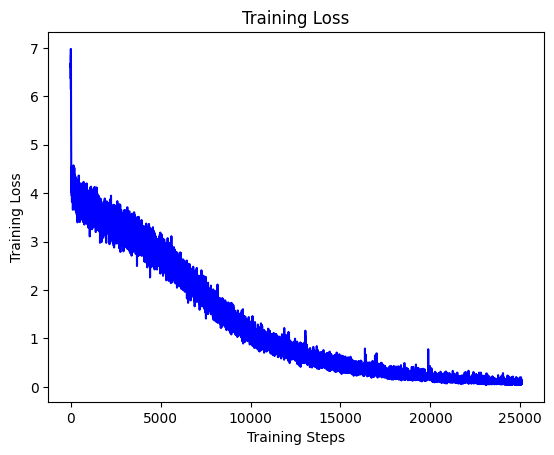

In [18]:
# plot the training loss graph
loss_graph(train_loss)

In [19]:
# load the test data
import pickle

with open('/content/drive/MyDrive/NLP Project/test_buckets.pickle', 'rb') as f:
    test_buckets = pickle.load(f)

In [217]:
# calculate the prediction
preds_bucket_beam = predict_beam(test_buckets[current_index][0:100])
preds_bucket_beam

[('shab bakhair', 'walay hain yn they'),
 ('mehfhil mein aap ka kher muqaddam hai',
  'mehfhil mein hai 1 hon sarah hain pehlay !'),
 ('aur khawab khar gosh', 'aur misl bhiya hum yn hum'),
 ('aglay sabaq mein kitni der hai ustaad mohtaram',
  'aglay sabaq mohtaram sarah hai jawab hai pakistan hai ki'),
 ('Tafseer muki', 'younis . mujhe 2007'),
 ('bees tareekh hai jummay al ki', 'bees qist ke hai 1 hai 1 hai'),
 ('aur aap ko duayen den ge', 'aur aap gi sarah hain hum yn aap'),
 ('ki rahi meri aaj ki ki', 'ki pata azam hon ki ja kyun den'),
 ('mujhe jawab ka intzaar rahay ga : )',
  'mujhe ik ) yeh hai ki hai jawab hai jawab'),
 ('ki do nai kara den', 'ki gaari hain ki hain ki hain'),
 ('jo munasib ke Wilayat ke hain makhsoos',
  'jo munasib ton ki hai ke hai din hai'),
 ('itnay achay ke mein ( jo Shakir )',
  'itnay achay shakir hum hain sab hain kehte hain sab'),
 ('tig : shairi , ghazal , nasir Hussain',
  'tig : nasir kitaab 1 hai 1 hai 1 hai'),
 ('khud ko ko', 'ko pohanchi usay zila

In [215]:
# quantitaive analysis - bleu score of model, rouge score
print('beam search')
bleu_score = calculate_bleu_score(preds_bucket_beam)
rouge = evaluate.load('rouge')
expected = [pair[0] for pair in preds_bucket_beam]
predicted = [pair[1] for pair in preds_bucket_beam]
rouge_score = rouge.compute(predictions=predicted, references=expected)
print("BLEU SCORE OF BUCKET SIZE 10:", bleu_score)
print("ROUGE SCORE OF BUCKET SIZE 10:", rouge_score)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

BLEU SCORE OF BUCKET SIZE 10: 8.793816932193118e-77
ROUGE SCORE OF BUCKET SIZE 10: {'rouge1': 0.2448761377511377, 'rouge2': 0.062223748473748494, 'rougeL': 0.23800330225330224, 'rougeLsum': 0.23775333000332993}


In [218]:
# calculate the prediction
preds_bucket_greedy = predict_greedy(test_buckets[current_index][0:100])
preds_bucket_greedy

0 test examples done, 100 left.
all done!


[('shab bakhair', 'ke gala'),
 ('mehfhil mein aap ka kher muqaddam hai',
  'mehfhil mein aap ka kher muqaddam hai'),
 ('aur khawab khar gosh', 'ke gumaan tishna shikan'),
 ('aglay sabaq mein kitni der hai ustaad mohtaram',
  'aglay sabaq mein kitni der hai ustaad mohtaram'),
 ('Tafseer muki', ', 2008'),
 ('bees tareekh hai jummay al ki', 'bees tareekh hai jummay al ki ki'),
 ('aur aap ko duayen den ge', 'aur aap ko duayen den ge'),
 ('ki rahi meri aaj ki ki', 'ki rahi hamein aaj ki ki'),
 ('mujhe jawab ka intzaar rahay ga : )',
  'mujhe jawab ka intzaar rahay ga : )'),
 ('ki do nai kara den', 'ki gaari shuda mulaqaat den'),
 ('jo munasib ke Wilayat ke hain makhsoos',
  'jo munasib ke masawaat ke hain makhsoos'),
 ('itnay achay ke mein ( jo Shakir )', 'itnay achay ke mein ( jo shakir )'),
 ('tig : shairi , ghazal , nasir Hussain',
  'tig : shairi , ghazal , nasir hussain'),
 ('khud ko ko', 'ko suna'),
 ('baghaawat mujh se hain narmi', 'kab haar paich hain narmi'),
 ('khud kash dhamakay 

In [219]:
# quantitaive analysis - bleu score of model, rouge score
print('greedy search')
bleu_score = calculate_bleu_score(preds_bucket_greedy)
rouge = evaluate.load('rouge')
expected = [pair[0] for pair in preds_bucket_greedy]
predicted = [pair[1] for pair in preds_bucket_greedy]
rouge_score = rouge.compute(predictions=predicted, references=expected)
print("BLEU SCORE OF BUCKET SIZE 10:", bleu_score)
print("ROUGE SCORE OF BUCKET SIZE 10:", rouge_score)

greedy search


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

BLEU SCORE OF BUCKET SIZE 10: 54.66639309944521
ROUGE SCORE OF BUCKET SIZE 10: {'rouge1': 0.6353253968253969, 'rouge2': 0.51879329004329, 'rougeL': 0.6364694749694749, 'rougeLsum': 0.6369771062271061}


In [220]:
# qualitative analysis - lets see a few example sentences and their transliterations
# since greedy gave better performance on quant. metrics, we are just showing the sentences using greedy approach.
for i in range(10):
  inx = random.randint(0, len(preds_bucket_greedy))
  r, u = test_buckets[current_index][inx]
  print('Urdu Sentence:', u.replace('<start>', '').replace('<end>', '').strip())
  print('Actual Roman Urdu Sentence:', r.replace('<start>', '').replace('<end>', '').strip())
  orig, pred = preds_bucket_greedy[inx]
  print('Predicted Roman Urdu Sentence:', pred.replace('<start>', '').replace('<end>', '').strip())
  print()

Urdu Sentence: اپ کے لیے ایک شعر
Actual Roman Urdu Sentence: aap ke liye aik shair
Predicted Roman Urdu Sentence: ke dobarah dosra aik shair

Urdu Sentence: اچانک نظر کا پڑنا اور ناپسندیدہ نظر
Actual Roman Urdu Sentence: achanak nazar ka parna aur napasandeedah nazar
Predicted Roman Urdu Sentence: achanak nazar ka merg aur toseefi nazar

Urdu Sentence: مصطفی زیدی ( 1 )
Actual Roman Urdu Sentence: mustafa Hussain ( 1 )
Predicted Roman Urdu Sentence: raahat hussain 56 1 )

Urdu Sentence: یہاں بھی بارش ہورہی ہے
Actual Roman Urdu Sentence: yahan bhi barish horahee hai
Predicted Roman Urdu Sentence: yahan to khusi horahee hai

Urdu Sentence: اقتباس کیسے کرنا ھے
Actual Roman Urdu Sentence: iqtabas kaisay karna he
Predicted Roman Urdu Sentence: hai khana baat he

Urdu Sentence: مستقل نہیں ہوتا
Actual Roman Urdu Sentence: mustaqil nahi hota
Predicted Roman Urdu Sentence: wahan aaya herani

Urdu Sentence: محفل میں اپ کا خیر مقدم ہے
Actual Roman Urdu Sentence: mehfhil mein aap ka kher muqaddam h